<a href="https://colab.research.google.com/github/vijjus/CV/blob/master/PerformerEMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!uname -a

Linux 574760b12c31 4.19.112+ #1 SMP Thu Jul 23 08:00:38 PDT 2020 x86_64 x86_64 x86_64 GNU/Linux


In [2]:
!nvidia-smi

Tue May  4 20:49:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install performer-pytorch

  Created wheel for axial-positional-embedding: filename=axial_positional_embedding-0.2.1-cp37-none-any.whl size=2905 sha256=c083dde1dde8f4a902856a809f5cd5b93ed789fc922ae066b856c56f94c77263
  Stored in directory: /root/.cache/pip/wheels/cd/f8/93/25b60e319a481e8f324dcb1871aff818eb0c8143ed20b732b4
Successfully built axial-positional-embedding


In [4]:
!pip install vit-pytorch

In [5]:
!pip install colorama

In [6]:
import cv2
import sys
import random
import torch
import collections
import editdistance
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from colorama import Fore
from itertools import groupby
import albumentations as A
import torch.nn.functional as F
from google.colab import drive
import matplotlib.pyplot as plt
from vit_pytorch.vit import PreNorm, Attention, Transformer
from performer_pytorch import Performer
from albumentations.pytorch import ToTensor

In [7]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [8]:
!ls /content/gdrive/Shareddrives/Doxie.ai/Bancoft\ Library/train_images

field_crop.zip	field_train_data.txt


In [9]:
!cp  /content/gdrive/Shareddrives/Doxie.ai/Bancoft\ Library/train_images/field_crop.zip .

In [10]:
!cp  /content/gdrive/Shareddrives/Doxie.ai/Bancoft\ Library/train_images/field_train_data.txt .

In [11]:
!rm -rf images; mkdir images; mv field_crop.zip images

In [ ]:
!cd images; unzip field_crop.zip; cd -

In [13]:
data_dict = {}
with open('field_train_data.txt', 'r') as f:
  for line in f:
    line = line.rstrip('\n')
    if line[0] == '"':
      line = line.lstrip('"')
      line = line.rstrip('"')
    items = line.split('; ')
    imfile = "/content/images/" + items[0]
    text = ' '.join(items[1:])
    data_dict[imfile] = text

In [51]:
data = list(data_dict.keys())
print(f'{len(data)} items found..')

2669 items found..


Max height=117, width=966, label=49
There are 681 images with width more than 512px
 "#&'(),-./0123456789ABCDEFGHIJKLMNOPRSTUVWYZabcdefghijklmnopqrstuvwxyz


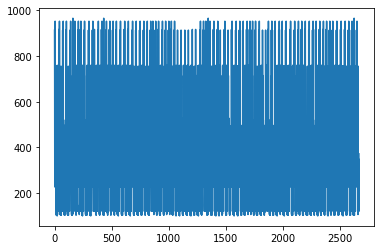

In [55]:
max_h=0
max_w=0
max_l=0
large=[]
widths=[]
vocab = set()
for imfile in data:
  img = cv2.imread(imfile, cv2.IMREAD_GRAYSCALE)
  max_w = max(max_w, img.shape[1])
  widths.append(img.shape[1])
  if img.shape[1] > 512:
    max_h = max(max_h, img.shape[0])
    large.append(imfile)
  text = data_dict[imfile]
  max_l = max(max_l, len(text))
  for c in text:
    if c not in vocab:
      vocab.add(c)
print(f'Max height={max_h}, width={max_w}, label={max_l}')
print(f'There are {len(large)} images with width more than 512px')
vocab = list(vocab)
vocab.sort()
print(''.join(vocab))
plt.plot(widths)

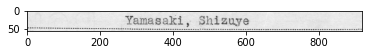

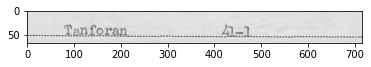

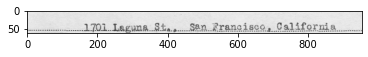

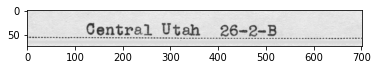

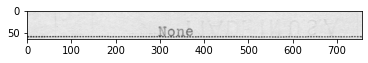

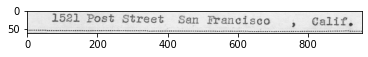

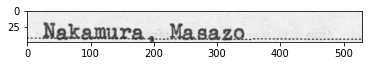

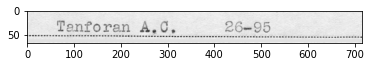

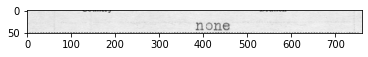

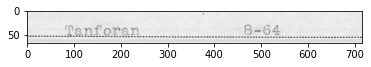

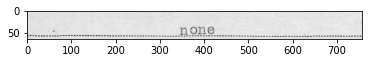

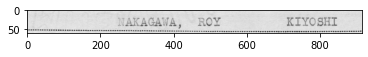

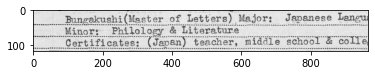

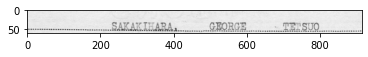

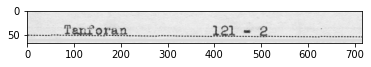

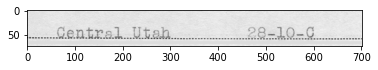

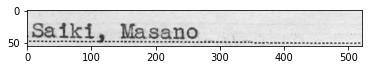

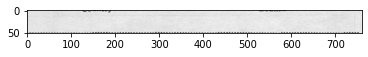

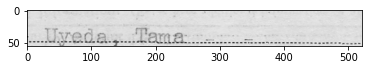

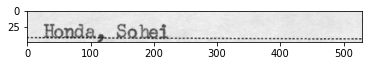

In [56]:
for k in range(20):
  imfile = large[random.randint(0,len(large)-1)]
  img = cv2.imread(imfile, cv2.IMREAD_GRAYSCALE)
  plt.imshow(img, cmap='gray')
  plt.show()

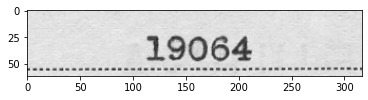

Label: 19064


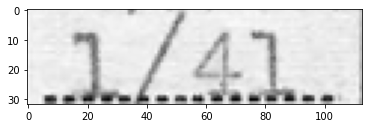

Label: 1/41


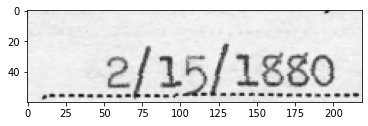

Label: 2/15/1880


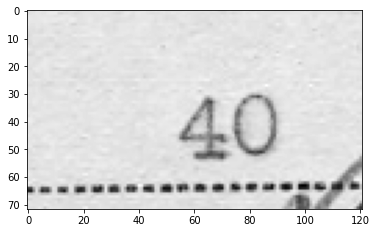

Label: 40


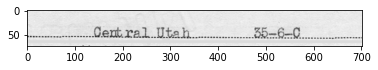

Label: Central utah 35-6-C


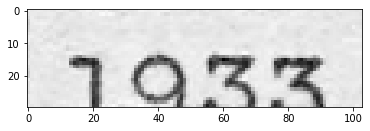

Label: 1933


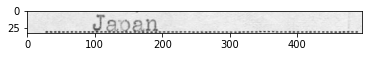

Label: Japan


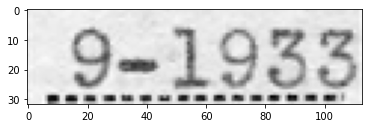

Label: 9-1933


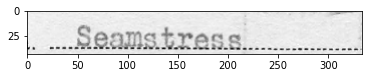

Label: Seamstress


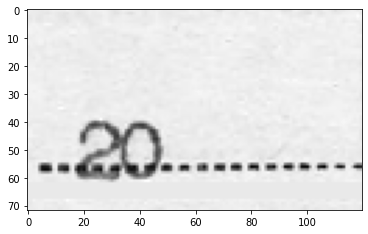

Label: 20


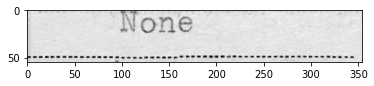

Label: None


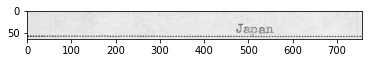

Label: Japan


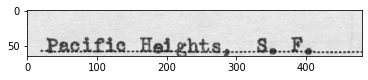

Label: Pacific Heights, S.F.


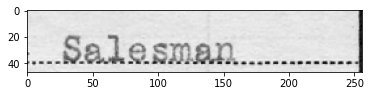

Label: Salesman (Jewlry)


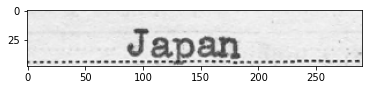

Label: Japan


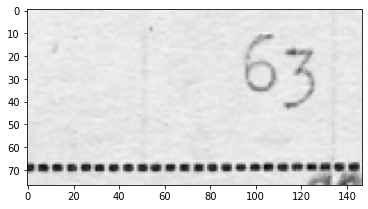

Label: 63


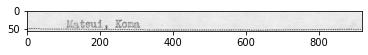

Label: Matsui, Koma


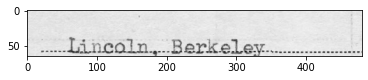

Label: Lincoln, Berkeley


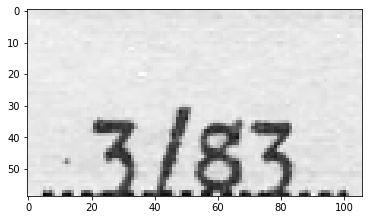

Label: Mar-83


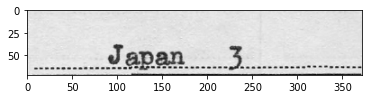

Label: Japan 3


In [20]:
for k in range(20):
  imfile = data[random.randint(0,2668)]
  img = cv2.imread(imfile, cv2.IMREAD_GRAYSCALE)
  plt.imshow(img, cmap='gray')
  plt.show()
  print(f"Label: {data_dict[imfile]}")

In [57]:
random.shuffle(large)
num_total = len(large)
num_train = int(0.8 * num_total)
train_data = large[:num_train]
val_data = large[num_train:]

In [58]:
def statX(inp):
    print(f'min={inp.min():.2f}, max={inp.max():.2f}, mean={inp.mean():.2f}, var={inp.var():.2f}, std={inp.std():.2f}')

In [77]:
class JACSData(torch.utils.data.Dataset):
  def __init__(self, files, mdict, dshape=(120, 1000), transform=None):
    self.files = files
    self.master_dict = mdict
    self.transform = transform
    self.data_shape = dshape

    vocab = " \"#&'(),-./0123456789ABCDEFGHIJKLMNOPRSTUVWYZabcdefghijklmnopqrstuvwxyz"
    self.vdict = {k: v for v, k in enumerate(vocab)}

  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    imfile = self.files[index]
    img = cv2.imread(imfile, cv2.IMREAD_GRAYSCALE)

    # invert the pixels
    img = img.max() - img

    # resize image to fixed height
    # resizing method depends on whether we are shrinking or blowing up the image
    if img.shape[0] > self.data_shape[0] and img.shape[1] > self.data_shape[1]:
      #neww = min(int(hscale * img.shape[1]), img.shape[1])
      resimg = cv2.resize(img, (self.data_shape[1], self.data_shape[0]), cv2.INTER_CUBIC)
      
      # resize to fixed width by adding zeros
      #resimg = np.zeros(self.data_shape)
      #resimg[0:img.shape[0], 0:img.shape[1]] = img
    else:
      resimg = cv2.resize(img, (self.data_shape[1], self.data_shape[0]), cv2.INTER_LINEAR)

    if self.transform is not None:
      resimg = self.transform(image=resimg)['image']

    label = self.master_dict[imfile]
    #y = torch.zeros(50, dtype=torch.int)
    #try:
    #  for k, l in enumerate(label):
    #    y[k] = self.vdict[l]
    #except KeyError as e:
    #  print(f'Image={imfile} w/ label={label}: {k},{l}')

    return (resimg.permute(1,0).unsqueeze(0), label)

In [64]:
train_transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=3, p=.3),
    A.OpticalDistortion(p=0.3),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensor(),
])

In [78]:
train_set = JACSData(train_data, data_dict, transform=train_transform, dshape=(50,500))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)

In [79]:
data = next(iter(train_loader))

Manabe, Takeji
min=-0.97, max=0.25, mean=-0.83, var=0.04, std=0.19


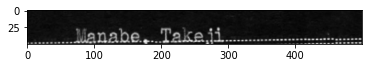

Fujisaki, Mitsuko
min=-0.94, max=0.57, mean=-0.76, var=0.05, std=0.21


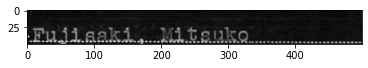

Tamada, Chiyo (dec.)
min=-0.94, max=0.52, mean=-0.75, var=0.04, std=0.21


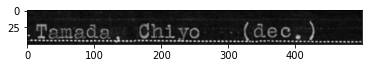

1616 Russel Berkeley, Calif.
min=-0.95, max=0.48, mean=-0.73, var=0.05, std=0.23


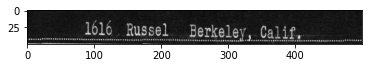

Central Utah 11-5-B
min=-0.90, max=0.11, mean=-0.79, var=0.02, std=0.14


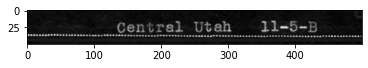

Mizokami, Saki
min=-0.90, max=0.36, mean=-0.71, var=0.06, std=0.25


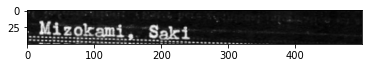

Central Utah 20-4-A
min=-0.98, max=0.40, mean=-0.79, var=0.03, std=0.18


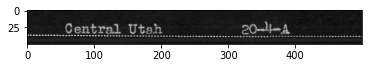

Tanforan 25-16
min=-0.98, max=0.34, mean=-0.85, var=0.02, std=0.15


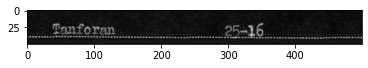

Japan
min=-0.97, max=0.57, mean=-0.75, var=0.04, std=0.19


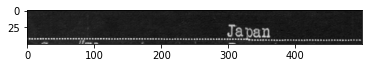

Ihara, Sadakichiro
min=-0.89, max=0.29, mean=-0.76, var=0.03, std=0.17


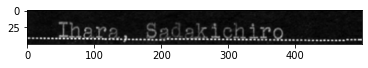

Japan See #31
min=-0.91, max=0.23, mean=-0.80, var=0.02, std=0.13


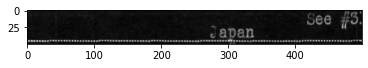

KITAMURA RYOICHI GEORGE
min=-0.90, max=0.25, mean=-0.77, var=0.02, std=0.16


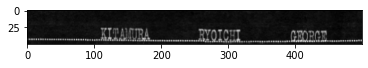

In [76]:
for k in range(12):
    print(data[1][k])
    statX(data[0][k])
    plt.imshow(data[0][k].squeeze(0), cmap='gray')
    plt.show()

In [80]:
val_transform = A.Compose([
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensor(),
])

In [81]:
val_set = JACSData(val_data, data_dict, transform=val_transform, dshape=(50,500))
val_loader = torch.utils.data.DataLoader(val_set, batch_size=8, shuffle=True)

SHIMOKUSU, KAZIO JACK
min=-0.95, max=0.49, mean=-0.78, var=0.03, std=0.18


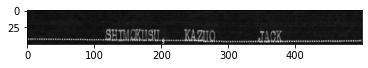

In [82]:
data = next(iter(val_loader))
for k in range(1):
    print(data[1][k])
    statX(data[0][k])
    plt.imshow(data[0][k].squeeze(0), cmap='gray')
    plt.show()

In [34]:
class strLabelConverter(object):
    """Convert between str and label.
    NOTE:
        Insert `blank` to the alphabet for CTC.
    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet

        self.dict = {}
        for i, char in enumerate(alphabet):
            self.dict[char] = i

    def encode(self, text):
        """Support batch or single str.
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, torch.Tensor):
            if text.dim() == 2:
                label = []
                length = []
                for sub in text:
                    l = [self.dict[str(x)] for x in sub.tolist()]
                    label.append(l)
                    length.append(len(sub))
                text = label
            else:
                text = [self.dict[str(x)] for x in text.tolist()]
                length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.
        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i]])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts

In [35]:
encoder = strLabelConverter(vocab, ignore_case=False)

In [36]:
epochs = 20
num_classes = len(vocab) + 1
blank_label = len(vocab)
print(num_classes, blank_label)
gru_hidden_size = 512
gru_num_layers = 2
cnn_output_height = 32
cnn_output_width = 50

72 71


In [37]:
class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5), stride=2)
        self.norm1 = nn.InstanceNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3))
        self.norm4 = nn.InstanceNorm2d(64)
        self.gru_input_size = cnn_output_height * 64
        self.gru = nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(gru_hidden_size * gru_num_layers, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        #print(f'After CNN: {out.shape}')
        out = out.permute(0, 3, 2, 1)
        out = out.reshape(batch_size, -1, self.gru_input_size)
        #print(f'Before GRU: {out.shape}')
        out, _ = self.gru(out)
        #print(f'After GRU: {out.shape}')
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out

In [38]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params / 1000000

In [39]:
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from torch.nn import Conv2d, Dropout, LogSoftmax
from einops.layers.torch import Rearrange

In [160]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, 
                 depth, heads, mlp_dim, pool = 'mean', channels = 3, 
                 dim_head = 64, dropout = 0., emb_dropout = 0.,
                 patch_method = "linear"):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        if patch_method == "linear":
          self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
          )
        else:
          self.to_patch_embedding = nn.Conv2d(
            in_channels=channels,
            out_channels=dim,
            kernel_size=patch_size,
            stride=patch_size,
          )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

        self._log_softmax = LogSoftmax(dim=-1)

    def forward(self, img):
        #print(f'Image shape: {img.shape}')
        x = self.to_patch_embedding(img)
        # convolutional embedding produces an extra dimension
        if len(x.shape) == 4:
          x = x.flatten(2)
          x = x.transpose(-1, -2)
        #print(f'After patch embedding: {x.shape}')
        b, n, _ = x.shape

        x += self.pos_embedding[:, :n]
        #print(f'after pos embedding: {x.shape}')
        x = self.dropout(x)
        #print(f'Before transformer: {x.shape}')
        x = self.transformer(x)
        #print(f'After transformer: {x.shape}')

        batch_len, sequence_len, hidden_len = x.shape

        x = x.view(-1, hidden_len)
        logits = self.mlp_head(x)
        logits = logits.view(batch_len, sequence_len, -1)
        logits = self._log_softmax(logits)
        logits = logits.permute(1, 0, 2)
        
        #print(f'After logits: {logits.shape}')
        return logits

In [169]:
del model

In [170]:
#model = CRNN()
model = ViT(image_size=(50, 500), patch_size=(50, 5), num_classes=(len(vocab)+1),
            depth=6, dim=512, mlp_dim=2048, heads=6, channels=1, patch_method="cnn")

In [171]:
x = torch.randn(1,1,50,500)
out = model(x)
out.shape

torch.Size([100, 1, 72])

In [172]:
model = model.cuda()

In [173]:
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=5, verbose=True)

In [174]:
print(f"Model has {count_parameters(model):.2f}M parameters")

Model has 17.55M parameters


In [175]:
epochs=100

In [176]:
# ================================================ TRAINING MODEL ======================================================
best_ed = np.inf
for epoch in range(epochs):
    # ============================================ TRAINING ============================================================
    train_correct = 0
    train_total = 0
    model.train()
    train_loss = 0.0
    train_ed = 0
    train_cc = 0
    for x_train, y_train in tqdm(train_loader,
                                 position=0, leave=True,
                                 file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
        batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
        # x_train = x_train.view(x_train.shape[0], 1, x_train.shape[2], -1)
        t, l = encoder.encode(y_train)
        optimizer.zero_grad()
        
        y_pred = model(x_train.cuda())
        
        #y_pred = y_pred.permute(1, 0, 2)  # y_pred.shape == torch.Size([64, 32, 11])
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        loss = criterion(y_pred, t.cuda(), input_lengths, l)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 32
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction):
              text = [vocab[k] for k in prediction]
              train_ed += editdistance.eval(text, y_train[i])
            else:
              train_ed += len(y_train[i])  # the entire string is missing
            train_cc += len(y_train[i])
            train_total += 1
    print(f'TRAINING. editdistance: {train_ed}/{train_total}={train_ed/train_total:.3f}')
    print(f"[{epoch}] Train loss: {train_loss:.2f}, avg. char count={train_cc/train_total:.3f}")

    scheduler.step(train_loss)

    # ============================================ VALIDATION ==========================================================
    val_correct = 0
    val_total = 0
    model.eval()
    val_loss = 0.0
    val_ed = 0
    val_cc = 0
    TO_DISPLAY = 10
    for x_val, y_val in val_loader:
        batch_size = x_val.shape[0]
        # x_val = x_val.view(x_val.shape[0], 1, x_val.shape[2], -1)
        t, l = encoder.encode(y_val)

        with torch.set_grad_enabled(False):
            y_pred = model(x_val.cuda())

        #y_pred = y_pred.permute(1, 0, 2)
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        loss = criterion(y_pred, t.cuda(), input_lengths, l)

        val_loss += loss.item()

        _, max_index = torch.max(y_pred, dim=2)
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction):
              text = ''.join([vocab[k] for k in prediction])
              val_ed += editdistance.eval(text, y_val[i])
            else:
              text = ''
              val_ed += len(y_val[i])
            val_cc += len(y_val[i])
            val_total += 1
            if val_total < TO_DISPLAY:
              print(f"Output={text}\t Label={y_val[i]}")
    # save best weights
    if val_ed < best_ed:
      best_ed = val_ed
      print("Best model seen, saving weights...")
      torch.save(model.state_dict(), "/content/gdrive/MyDrive/CRNN_Text.pth")
    print(f'TESTING editdistance:  {val_ed}/{val_total} = {val_ed/val_total:.3f}')
    print(f"[{epoch}] Test loss: {val_loss:.2f}, avg char count: {val_cc/val_total:.3f}")


100%|██████████| 34/34 [00:02<00:00, 15.87it/s]
TRAINING. editdistance: 10031/544=18.439
[0] Train loss: 164.14, avg. char count=16.232
Output=	 Label=KOBAYASHI TOMEKI
Output=	 Label=None
Output=	 Label=MITA MAKOTO
Output=	 Label=Central Utah 26-7-D
Output=	 Label=None
Output=	 Label=ITO MIDORI JOANNE
Output=	 Label=none
Output=	 Label=Central Utah 35-6-C
Output=	 Label=Matsuoka, Wataru
Best model seen, saving weights...
TESTING editdistance:  2353/137 = 17.175
[0] Test loss: 76.50, avg char count: 17.175
100%|██████████| 34/34 [00:02<00:00, 15.92it/s]
TRAINING. editdistance: 8830/544=16.232
[1] Train loss: 140.66, avg. char count=16.232
Output=	 Label=Hoshiga, Genichi
Output=	 Label=None
Output=	 Label=NAMBA SHIZU
Output=	 Label=1800 Buchanan Street San Francisco, California
Output=	 Label=none
Output=	 Label=Sakurai, Koyme
Output=	 Label=Mori, Torao
Output=	 Label=Central Utah 26-7-D
Output=	 Label=110 Monte Ave. Piedmont Calif.
TESTING editdistance:  2353/137 = 17.175
[1] Test loss:

In [ ]:
count=0
COUNT=40
for x_val, y_val in val_loader:
    batch_size = x_val.shape[0]
    # x_val = x_val.view(x_val.shape[0], 1, x_val.shape[2], -1)
    t, l = encoder.encode(y_val)

    with torch.set_grad_enabled(False):
        y_pred = model(x_val.cuda())

    y_pred = y_pred.permute(1, 0, 2)
    _, max_index = torch.max(y_pred, dim=2)
    for i in range(batch_size):
        raw_prediction = list(max_index[:, i].detach().cpu().numpy())
        prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
        try:
          if len(prediction):
            text = ''.join([vocab[k] for k in prediction])
            print(f"Output={text},\t Label={y_val[i]}")
        except IndexError:
          pass
        count += 1
    if count > COUNT:
      break

In [31]:
from einops.layers.torch import Rearrange

In [43]:
img = torch.randn(1,1,32,512)

In [48]:
R = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = 32, p2 = 8)

In [49]:
r = R(img)
r.shape

torch.Size([1, 64, 256])

In [25]:
transformer = Performer(
    dim=512,
    depth=1,
    heads=8,
    dim_head=64,
    causal=True
)

unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version


In [39]:
model = ViT(
    image_size=512,
    patch_size=8,
    num_classes=11,
    dim=512,
    channels=1,
    transformer=transformer,
)

In [30]:
model

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)
    (1): Linear(in_features=64, out_features=512, bias=True)
  )
  (transformer): Performer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreLayerNorm(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (fn): SelfAttention(
              (fast_attention): FastAttention(
                (kernel_fn): ReLU()
              )
              (to_q): Linear(in_features=512, out_features=512, bias=True)
              (to_k): Linear(in_features=512, out_features=512, bias=True)
              (to_v): Linear(in_features=512, out_features=512, bias=True)
              (to_out): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (1): PreLayerNorm(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_a

In [40]:
x = torch.randn(1, 16, 32)

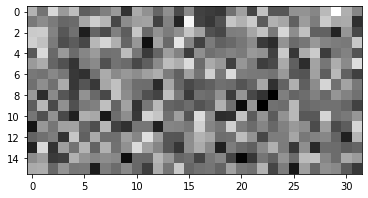

In [41]:
plt.imshow(x.squeeze(0), cmap='gray')

In [43]:
out = model(x.unsqueeze(0))
out.shape

torch.Size([1, 11])

In [44]:
out

tensor([[ 1.8996, -0.0451,  0.5881, -0.6383, -0.5154, -0.7162, -0.1623,  0.5851,
         -0.4277,  0.7611,  0.6347]], grad_fn=<AddmmBackward>)